In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Warm-ups/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/Warm-ups'

In [84]:
class NPYImageDataset(DatasetFolder):
    def __init__(self, root_dir, loader, extensions, transform):
        """
        Args:
            root_dir (string): Directory with all the images in subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.loader = loader
        self.transform = transform
        self.extensions = extensions
        self.samples = []
        self.classes = ['no', 'sphere', 'vort']
        self.labels = {'no': 0, 'sphere': 1, 'vort': 2}

        for label in self.classes:
            label_dir = os.path.join(self.root_dir, label)
            for fname in os.listdir(label_dir):
                if fname.endswith('.npy'):
                    self.samples.append((os.path.join(label_dir, fname), self.labels[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.load(img_path)

        # Convert NumPy array to PIL Image
        image = Image.fromarray(image.astype('uint8'), 'RGB')

        if self.transform:
            image = self.transform(image)

        # Hugging Face expects 'labels', not 'label'
        return {'pixel_values': image, 'labels': label}

# Define your transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instances
train_dataset = NPYImageDataset(
    root_dir='../dataset/train',
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = NPYImageDataset(
    root_dir='../dataset/val',
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [85]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0]["pixel_values"].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0]["pixel_values"].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([3, 224, 224])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 422


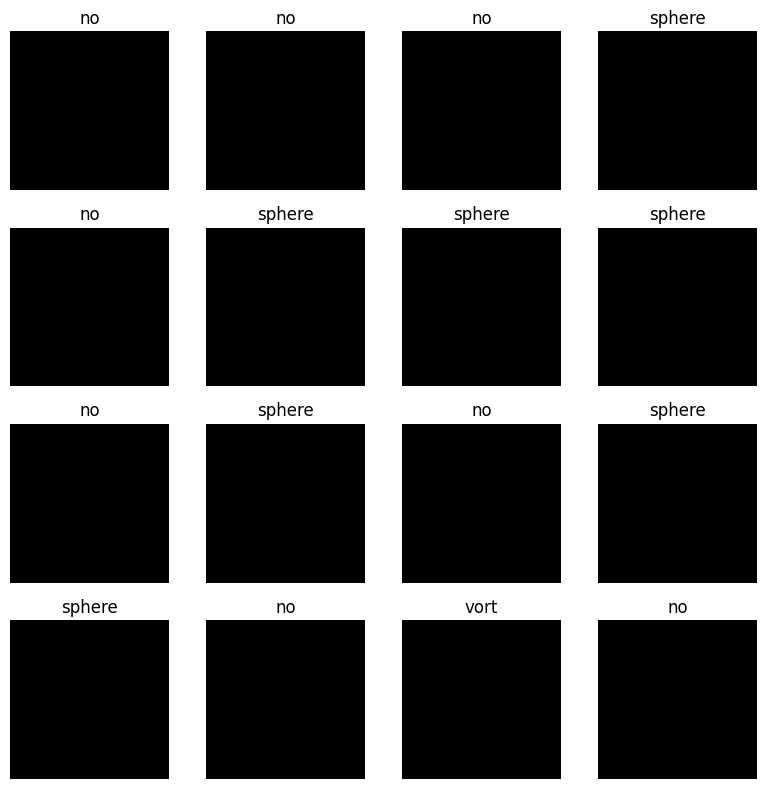

In [86]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

dataiter = iter(train_loader)
batch = next(dataiter)
images, labels = batch['pixel_values'], batch['labels']

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < 16:
        img = images[i].detach()  # Assuming images[i] is a tensor
        img = img.permute(1, 2, 0).numpy()  # Rearrange dimensions to height x width x channels for plotting
        img = std * img + mean  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip to ensure valid image range
        label = labels[i].item()  # Assuming labels are tensor
        
        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])  # Direct access to classes
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()


In [91]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer

id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
label2id = {'no': 0, 'sphere': 1, 'vort': 2}

model_ViT = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    id2label=id2label,
    label2id=label2id
)
model_ViT.classifier = nn.Linear(in_features=768, out_features=3, bias=True)
model_ViT.to(device)

optimizer = optim.Adam(model_ViT.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()

model_ViT

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [88]:
for batch in train_loader:
    print("Pixel values:", batch['pixel_values'].shape)
    break

Pixel values: torch.Size([64, 3, 224, 224])


In [96]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return dict(accuracy=accuracy_score(preds, labels))

args = TrainingArguments(
    output_dir='../',
    num_train_epochs=10,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='../',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model_ViT,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [97]:
trainer.train()

  0%|          | 0/33750 [00:00<?, ?it/s]

{'loss': 1.0977, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 1.1, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 1.0959, 'learning_rate': 3e-06, 'epoch': 0.01}
{'loss': 1.1068, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
{'loss': 1.1004, 'learning_rate': 5e-06, 'epoch': 0.01}
{'loss': 1.1034, 'learning_rate': 6e-06, 'epoch': 0.02}
{'loss': 1.1002, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.02}
{'loss': 1.1086, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.02}
{'loss': 1.1098, 'learning_rate': 9e-06, 'epoch': 0.03}
{'loss': 1.0769, 'learning_rate': 1e-05, 'epoch': 0.03}
{'loss': 1.1472, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.03}
{'loss': 1.1088, 'learning_rate': 1.2e-05, 'epoch': 0.04}
{'loss': 1.0915, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.04}
{'loss': 1.1098, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.04}
{'loss': 1.1016, 'learning_rate': 1.5e-05, 'epoch': 0.04}
{'loss': 1.1327, 'learning_

In [66]:
torch.save(model_ViT.state_dict(), '../best_param_ViT.pt')

In [67]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Warm-ups/best_param_ViT.pt'))
model_ViT.load_state_dict(torch.load('../best_param_ViT.pt'))

<All keys matched successfully>

In [ ]:
def evaluate_model(trainer):
    # Use the trainer to make predictions on the test dataset
    preds = trainer.predict(test_dataset)
    logits = preds.predictions
    y_true = preds.label_ids

    # Calculate test loss
    test_loss = preds.metrics['test_loss']

    # Apply softmax to logits to get probabilities
    y_pred_probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    test_acc = accuracy_score(y_true, y_pred)
    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    # print(f'Outputs: {outputs}')
    # print(f'Probabilities: {F.softmax(logits, dim=1)}, {logits.shape}')
    classes = ['no', 'sphere', 'vort']
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='red', label=f'ViT, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

Test Loss: 1.1000
Accuracy: 0.3363
ROC AUC: 0.4996
Outputs: ImageClassifierOutput(loss=None, logits=tensor([[-0.0187,  0.0373, -0.1055],
        [-0.0339,  0.0178, -0.0565],
        [-0.0234,  0.0405, -0.1255],
        [ 0.0350,  0.0356, -0.1149],
        [-0.0637,  0.0534, -0.0780],
        [-0.0089,  0.0259, -0.0298],
        [ 0.0699,  0.0027, -0.0682],
        [ 0.0490, -0.0096, -0.0815],
        [ 0.0192,  0.0282, -0.0896],
        [ 0.0393,  0.0391, -0.0850],
        [ 0.0112,  0.0351, -0.0828],
        [ 0.0467,  0.0157, -0.0899]], device='cuda:0'), hidden_states=None, attentions=None)
Probabilities: tensor([[0.3362, 0.3556, 0.3082],
        [0.3299, 0.3475, 0.3226],
        [0.3368, 0.3590, 0.3041],
        [0.3495, 0.3497, 0.3008],
        [0.3215, 0.3615, 0.3170],
        [0.3317, 0.3434, 0.3248],
        [0.3564, 0.3332, 0.3104],
        [0.3545, 0.3344, 0.3111],
        [0.3441, 0.3472, 0.3087],
        [0.3469, 0.3468, 0.3063],
        [0.3408, 0.3490, 0.3102],
        [0.

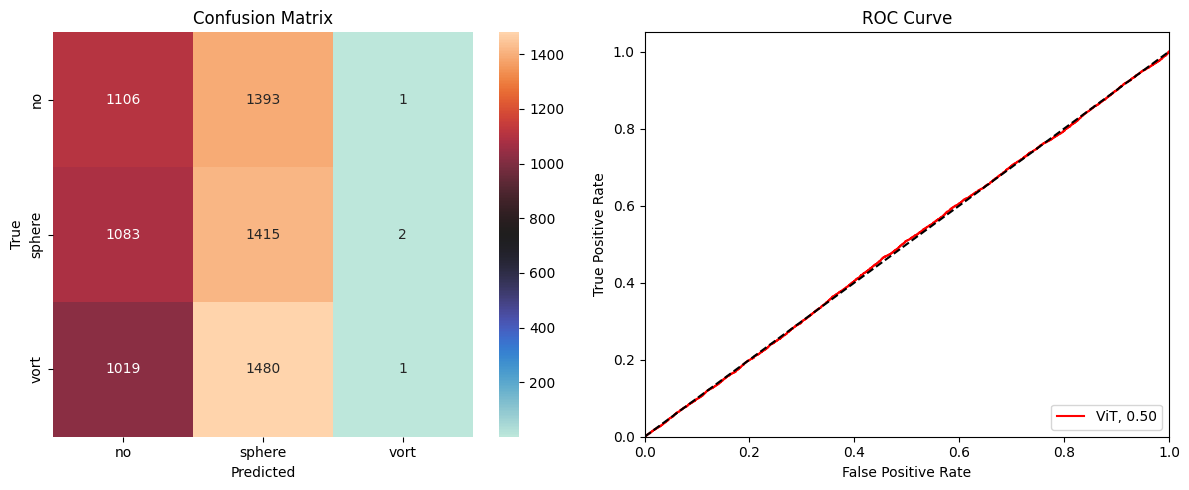

In [68]:
evaluate_model(model_ViT, criterion)